# Análise de Distribuidoras de Energias Elétricas do Brasil

## Objetivo:
O notebook atual tem como objetivo a coleta de dados no site de Dados Abertos da ANEEL para posterior análise.

## Libs:

In [168]:
! pip install --quiet requests 
! pip install --quiet pandas
! pip install --quiet numpy
! pip install --quiet seaborn
! pip install --quiet matplotlib
! pip install --quiet scikit-learn
import requests
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.cluster import KMeans



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bella\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bella\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bella\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bella\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\User

## Coleta:

In [3]:
# Varíaveis:

# API CKAN da ANEEL:
BASE_URL = "https://dadosabertos.aneel.gov.br/api/3/action/datastore_search"

# Datasets:
kpiDECFEC = "4493985c-baea-429c-9df5-3030422c71d7" # Dados de 2019 até 2029
kpiDECFEC_old = "b4dbdc46-a8a3-4e5d-9565-9f23b1156496" # Dados de 2010 até 2019
kpiCOMPCONT = "364d945e-a18b-4111-ab1b-73aa0f7b06b1" # Dados de 2019 até 2029
kpiCOMPCONT_old = "8cdad784-07c1-4a67-a285-2f2adce5df70" # Dados de 2010 até 2019
kpiLIMITES = "fd69e1dd-fd66-4269-b60c-cc0b7eb221b4" # Limites de DEC e FEC
kpiNAETMAE = "73b00e68-66b1-4a72-8d72-b7baab47048c"
kpiDRPDRC = "b6755d51-f537-4e0f-8fd8-d2cead66178a"
kpiCOMPCONF = "476d0490-a225-4de7-89a8-bb7a189f0868"
kpiCOMERCIAL = "11473878-1059-44f8-abf0-677212ff247b"
kpiINADIMPLENCIA = "0bb73b5d-b2e1-417d-9873-6de6b2d397d1"
kpiSEGURANCA = "ebe17185-a400-4f7a-a680-87c7d67f43dc"
kpiINDQUAL_MUN = "3f841488-80a8-42f2-a6ca-e0c593b228de"
kpiSATISFACAO = "7abd3a47-1e1a-4a33-933b-48d658a6f912"
kpiRECLAMACAO_old = "6c3e074c-d9ab-4840-8c6c-7993faa36ddb" # Dados de 2010 até 2022
kpiRECLAMACAO_2023 = "426f4fb2-6a89-452a-8236-cc48153ee607"
kpiRECLAMACAO_2024 = "4af32411-da8b-492c-ae15-8f615e35d2e2"
kpiRECLAMACAO_2025 = "83839c4e-78f9-4f68-bcb7-51dcfcf05c9c"
kpiTARIFAS = "fcf2906c-7c32-4b9b-a637-054e7a5234f4"
kpiAUTOINFRACAO = "f221158a-93a3-423f-b794-4312b6985a24"
kpiTERMONOTIFICACAO = "3aec3f42-5004-44e1-8b9c-4562084196f6"

# Domínios:
dominio = "e3724332-7de8-4273-8f0d-b20ebb91bf7c"
agentes = "64250fc9-4f7a-4d97-b0d4-3c090e005e1c"

## Funções & Definições:

In [4]:
# Visualizção do Dataframe:
pd.set_option('display.max_colwidth', None) 

In [33]:
# Salvamento de imagens:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "graficos")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [5]:
# Coletar dados na URL da ANEEL:
def coletar_dados_api(resource_id):
   # Variáveis locais:
    offset = 0
    total = []

    # Execução da função:
    while True:
        url = f"{BASE_URL}?resource_id={resource_id}&limit=10000&offset={offset}"
        resposta = requests.get(url)
        resposta.raise_for_status()    
        dados_json = resposta.json()
        
        registros = dados_json['result']['records']

        if not registros: # Encerrar se não tiver mais registros
                    break  
        
        total.extend(registros)
        offset += 10000
        print(f"Coletados {len(total)} registros.")

        # Formação do df:
        df = pd.DataFrame(registros)
    return df

def coletar_dados_csv(url_csv):
    df = pd.read_csv(url_csv, sep=";", encoding="latin1", decimal=',')

    return df

In [195]:
# Clusterização das distribuidoras por tamanho:
def clusterizacao_porte(df, coluna):
    coluna = coluna
    x = df[[coluna]].copy()

    # Aplicação do kMeans:
    kmeans = KMeans(n_clusters=3, random_state=42)
    df[f'{coluna}_CLUSTER'] = kmeans.fit_predict(x)

    cluster_order = df.groupby(f'{coluna}_CLUSTER')[coluna].mean().sort_values().index
    cluster_labels = ['Pequeno', 'Médio', 'Grande']
    label_map = {cluster_order[i]: cluster_labels[i] for i in range(3)}
    df[f'{coluna}_CATEGORIA'] = df[f'{coluna}_CLUSTER'].map(label_map)

    return df

cores_nuc = {
    'Pequeno': "#07a221",
    'Médio': "#0e22ff",
    'Grande': '#d62728'
}

## Análise

### Definições Gerais:

In [6]:
# Dataframe de domínio:
dfDom = coletar_dados_api(dominio)

# Ajustes do df:
dfDom.columns = dfDom.columns.str.upper()
dfDom = dfDom[['SIGINDICADOR','DSCINDICADOR']]

# Visualização:
dfDom.head()

Coletados 468 registros.


,SIGINDICADOR,DSCINDICADOR
0,AREA,"Área do conj., expressa em km2, correspondente a área geogr. e não a área elétr."
1,AREAT,Área do conjunto em km2
2,CM,Encargo de uso do sistema de distribuição aplicado à unidade cons. (mensal)
3,CMA,Encargo de uso do sistema de distribuição aplicado à unidade consumidora (anual)
4,CMM,"Consumo médio mensal, em MWh, média aritmética simples do último ano, excluin-"


In [7]:
# Dataframe de agentes:
dfAg = coletar_dados_api(agentes)

# Ajustes de colunas:
dfAg.columns = dfAg.columns.str.upper()
dfAg = dfAg.rename(columns={'SIGPESSOA':'SIGAGENTE'})

# Filtro de campos:
dfAg = dfAg[(dfAg['IDCATIVO'] == 'A') & (dfAg['IDCDISTRIBUICAO'] == '1')]

# Redução do df:
dfAg = dfAg[['SIGAGENTE','NOMRAZAOSOCIAL']]

# Visualização:
dfAg.head()

Coletados 9584 registros.


,SIGAGENTE,NOMRAZAOSOCIAL
103,ANATEL,AGENCIA NACIONAL DE TELECOMUNICACOES
104,ADASA,"AGENCIA REGULADORA DE AGUAS, ENERGIA E SANEAMENTO BASICO DO DISTRITO FEDERAL - ADASA"
294,AME,AMAZONAS ENERGIA S.A
319,ENEL RJ,AMPLA ENERGIA E SERVICOS S.A.
912,None,BOQUEIRAO ENERGIA LTDA


### Análise de DEC e FEC:

#### Preparação:

In [8]:
# Geração do dataframe:
dfDECFEC = coletar_dados_csv('https://dadosabertos.aneel.gov.br/dataset/d5f0712e-62f6-4736-8dff-9991f10758a7/resource/4493985c-baea-429c-9df5-3030422c71d7/download/indicadores-continuidade-coletivos-2020-2029.csv')

In [9]:
dfDECFECT = dfDECFEC

# Ajustes de colunas:
dfDECFECT.columns = dfDECFECT.columns.str.upper() # Colunas em maiúsculo
dfDECFECT = dfDECFECT[['SIGAGENTE','IDECONJUNDCONSUMIDORAS','SIGINDICADOR','ANOINDICE','NUMPERIODOINDICE','VLRINDICEENVIADO']]

# Join com o domínio:
dfDECFECT = pd.merge(dfDECFECT, dfDom, how='left', on='SIGINDICADOR')

# Join para selecionar apenas as distribuidoras ativas em 2025:
# ! Esse item não é utilizado porque o SIGAGENTE não dá match com o da ANEEL
#dfDECFECT = pd.merge(dfDECFECT, dfAg, how='inner', on='SIGAGENTE') 

dfDECFECT.head()

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO,DSCINDICADOR
0,EAC,12590,FECIPC,2020,1,0.00,"FEC interrup. origem inter. ao sist distr, prog. e ocorr. em dia crítico"
1,EAC,12590,DECXNC,2020,5,0.00,"DEC interrup. origem ext. ao sist distr, não prog. e ocorr. em dia crítico"
2,CEA,14566,FEC,2020,4,1.39,Freqüência Equivalente de Interrupção por Unidade Consumidora - 3 Min.
3,ETO,13623,DEC,2020,8,0.04,Duração Equivalente de Interrupção por Unidade Consumidora - 3 Min.
4,ETO,13660,FECXN,2020,1,0.00,FEC de interrupção de origem externa ao Sist. de Dist. e não programada


#### Definições das distribuidoras por unidades consumidoras:

In [193]:
# Avaliação da quantidade de clientes por distribuidora:
# ! Ajustar sempre para o último mês disponível ou para o mês de análise desejado:
dfDiscosInterresse = dfDECFECT[(dfDECFECT['ANOINDICE'] == 2025) & (dfDECFEC['NUMPERIODOINDICE'] == 7) & (dfDECFECT['SIGINDICADOR'] == 'NumCon')][['SIGAGENTE','VLRINDICEENVIADO']].groupby(by='SIGAGENTE').sum().reset_index()

# Filtro das distribuidoras com mais de 400 mil UCs (filtro ANEEL):
dfDiscosInterresse = dfDiscosInterresse[dfDiscosInterresse['VLRINDICEENVIADO'] > 400000]

# Renomeando colunas:
dfDiscosInterresse = dfDiscosInterresse.rename(columns={'VLRINDICEENVIADO': 'NUC'})

dfDiscosInterresse.head()

,SIGAGENTE,NUC
0,AME,906769.0
5,CEEE-D,1957930.0
8,CELESC,3469262.0
10,CEMIG-D,9431438.0
44,COELBA,6257879.0


In [247]:
# Definindo a categoria das distribuidoras de acordo com o porte:
dfDiscosInterresse = clusterizacao_porte(dfDiscosInterresse,'NUC')
dfDiscosInterresse.head()
dfDiscosInterresse.to_csv('base-clusterizacao.csv')

### Análise de compensação

#### Preparação:

In [174]:
# Geração do dataframe:
dfComp = coletar_dados_csv('https://dadosabertos.aneel.gov.br/dataset/d5f0712e-62f6-4736-8dff-9991f10758a7/resource/364d945e-a18b-4111-ab1b-73aa0f7b06b1/download/indicadores-continuidade-coletivos-compensacao-2020-2029.csv')

In [197]:
dfCompT = dfComp

# Ajustes de colunas:
dfCompT.columns = dfCompT.columns.str.upper() # Colunas em maiúsculo
dfCompT = dfCompT[['SIGAGENTE','IDECONJUNDCONSUMIDORAS','SIGINDICADOR','ANOINDICE','NUMPERIODOINDICE','VLRINDICEENVIADO']]

# Join com o domínio:
dfCompT = pd.merge(dfCompT, dfDom, how='left', on='SIGINDICADOR')

# Join para selecionar apenas as distribuidoras ativas em 2025:
# ! Esse item não é utilizado para compensação porque o SIGAGENTE não dá match com o da ANEEL
# dfCompT = pd.merge(dfCompT, dfAg, how='left', on='SIGAGENTE') 

dfCompT.head()

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO,DSCINDICADOR
0,EAC,12598,PGUGATT,2020,4,0.0,Valor pago a UGs AT por violacao dos limites de cont no trimestre
1,EAC,12589,PGUCATDC,2020,2,0.0,Valor pago as UCs AT por violacao dos limites de DICRI
2,EAC,12593,PGUGBTUDC,2020,1,0.0,Valor pago as UGs BT urbanas por violacao dos limites de DICRI
3,EAC,12596,QTUGMTNU,2020,7,0.0,Qtde de UGs MT não urbanas comp por violacao dos limites de cont no mes
4,ETO,13627,QTUGMTUA,2020,1,0.0,Qtde de UGs MT urbanas compens por violacao dos limites de cont no ano


In [198]:
# Separação dos indicadores:

## Tipologia do indicador:
dfCompT['INDICADOR'] = np.nan
dfCompT['INDICADOR'] = np.where(dfCompT['SIGINDICADOR'].astype(str).str.contains('PG'), 'DINHEIRO', dfCompT['INDICADOR'])
dfCompT['INDICADOR'] = np.where(dfCompT['SIGINDICADOR'].astype(str).str.contains('QT'), 'CLIENTES', dfCompT['INDICADOR'])

## Nível de Tensão do indicador:
dfCompT['TENSAO'] = np.nan
dfCompT['TENSAO'] = np.where(dfCompT['SIGINDICADOR'].astype(str).str.contains('BT'), 'BT', dfCompT['TENSAO'])
dfCompT['TENSAO'] = np.where(dfCompT['SIGINDICADOR'].astype(str).str.contains('AT'), 'AT', dfCompT['TENSAO'])
dfCompT['TENSAO'] = np.where(dfCompT['SIGINDICADOR'].astype(str).str.contains('MT'), 'MT', dfCompT['TENSAO'])

## Geração:
dfCompT['GERACAO'] = np.nan
dfCompT['GERACAO'] = np.where(dfCompT['SIGINDICADOR'].astype(str).str.contains('UG'), 1, dfCompT['GERACAO'])
dfCompT['GERACAO'] = np.where(dfCompT['SIGINDICADOR'].astype(str).str.contains('UC'), 0, dfCompT['GERACAO'])

## Localização (urbano ou rural):
dfCompT['URBANO'] = np.nan
dfCompT['URBANO'] = np.where(dfCompT['DSCINDICADOR'].astype(str).str.contains('urbana'), 1, dfCompT['URBANO'])
dfCompT['URBANO'] = np.where(dfCompT['DSCINDICADOR'].astype(str).str.contains('não urbana'), 0, dfCompT['URBANO'])

dfCompT.head()

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO,DSCINDICADOR,INDICADOR,TENSAO,GERACAO,URBANO
0,EAC,12598,PGUGATT,2020,4,0.0,Valor pago a UGs AT por violacao dos limites de cont no trimestre,DINHEIRO,AT,1.0,NaN
1,EAC,12589,PGUCATDC,2020,2,0.0,Valor pago as UCs AT por violacao dos limites de DICRI,DINHEIRO,AT,0.0,NaN
2,EAC,12593,PGUGBTUDC,2020,1,0.0,Valor pago as UGs BT urbanas por violacao dos limites de DICRI,DINHEIRO,BT,1.0,1.0
3,EAC,12596,QTUGMTNU,2020,7,0.0,Qtde de UGs MT não urbanas comp por violacao dos limites de cont no mes,CLIENTES,MT,1.0,0.0
4,ETO,13627,QTUGMTUA,2020,1,0.0,Qtde de UGs MT urbanas compens por violacao dos limites de cont no ano,CLIENTES,MT,1.0,1.0


In [199]:
# Verificação:
dfCompT[(dfCompT['INDICADOR'].isnull()) | (dfCompT['TENSAO'].isnull()) | (dfCompT['GERACAO'].isnull())]

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO,DSCINDICADOR,INDICADOR,TENSAO,GERACAO,URBANO


In [200]:
# Filtro das grandes distribuidoras apenas:
dfCompT = pd.merge(dfCompT, dfDiscosInterresse, how='inner', on = 'SIGAGENTE')

# Filtro para retirar as gerações:
dfCompT = dfCompT[dfCompT['GERACAO'] == 0]

In [201]:
# Visão final do dataframe:
dfCompT.head()

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO,DSCINDICADOR,INDICADOR,TENSAO,GERACAO,URBANO,NUC,NUC_CLUSTER,NUC_CATEGORIA
2,ETO,13621,QTUCBTUDC,2020,8,0.0,Qtde de UCs BT urbanas comp por violacao dos limites de DICRI,CLIENTES,BT,0.0,1.0,681872.0,2,Pequeno
3,ETO,13638,QTUCATT,2020,1,0.0,Qtde de UCs AT compens por violacao dos limites de cont no trimestre,CLIENTES,AT,0.0,NaN,681872.0,2,Pequeno
4,ETO,16028,QTUCMTUT,2020,3,0.0,Qtde de UCs MT urbanas compens por violacao dos limites de cont no trimestre,CLIENTES,MT,0.0,1.0,681872.0,2,Pequeno
5,ETO,16034,PGUCMTNUT,2020,3,0.0,Valor pago a UCs MT não urbanas por violacao dos limites de cont no trimestre,DINHEIRO,MT,0.0,0.0,681872.0,2,Pequeno
6,ETO,13621,QTUCBTNUDC,2020,11,3.0,Qtde de UCs BT não urbanas comp por violacao dos limites de DICRI,CLIENTES,BT,0.0,0.0,681872.0,2,Pequeno


In [202]:
# Validação dos indicadores restantes:
dfCompT.groupby(by=['SIGINDICADOR','DSCINDICADOR']).count().reset_index()[['SIGINDICADOR','DSCINDICADOR']]


,SIGINDICADOR,DSCINDICADOR
0,PGUCAT,Valor pago a UCs AT por violacao dos limites de continuidade no mes
1,PGUCATA,Valor pago a UCs AT por violacao dos limites de cont no ano
2,PGUCATDC,Valor pago as UCs AT por violacao dos limites de DICRI
3,PGUCATT,Valor pago a UCs AT por violacao dos limites de cont no trimestre
4,PGUCBTNU,Valor pago a UCs BT não urbanas por violacao dos limites de cont no mes
5,PGUCBTNUA,Valor pago a UCs BT não urbanas por violacao dos limites de cont no ano
6,PGUCBTNUDC,Valor pago as UCs BT não urbanas por violacao dos limites de DICRI
7,PGUCBTNUT,Valor pago a UCs BT não urbanas por violacao dos limites de cont no trimestre
8,PGUCBTU,Valor pago a UCs BT urbanas por violacao dos limites de continuidade no mes
9,PGUCBTUA,Valor pago a UCs BT urbanas por violacao dos limites de cont no ano


#### Análise:

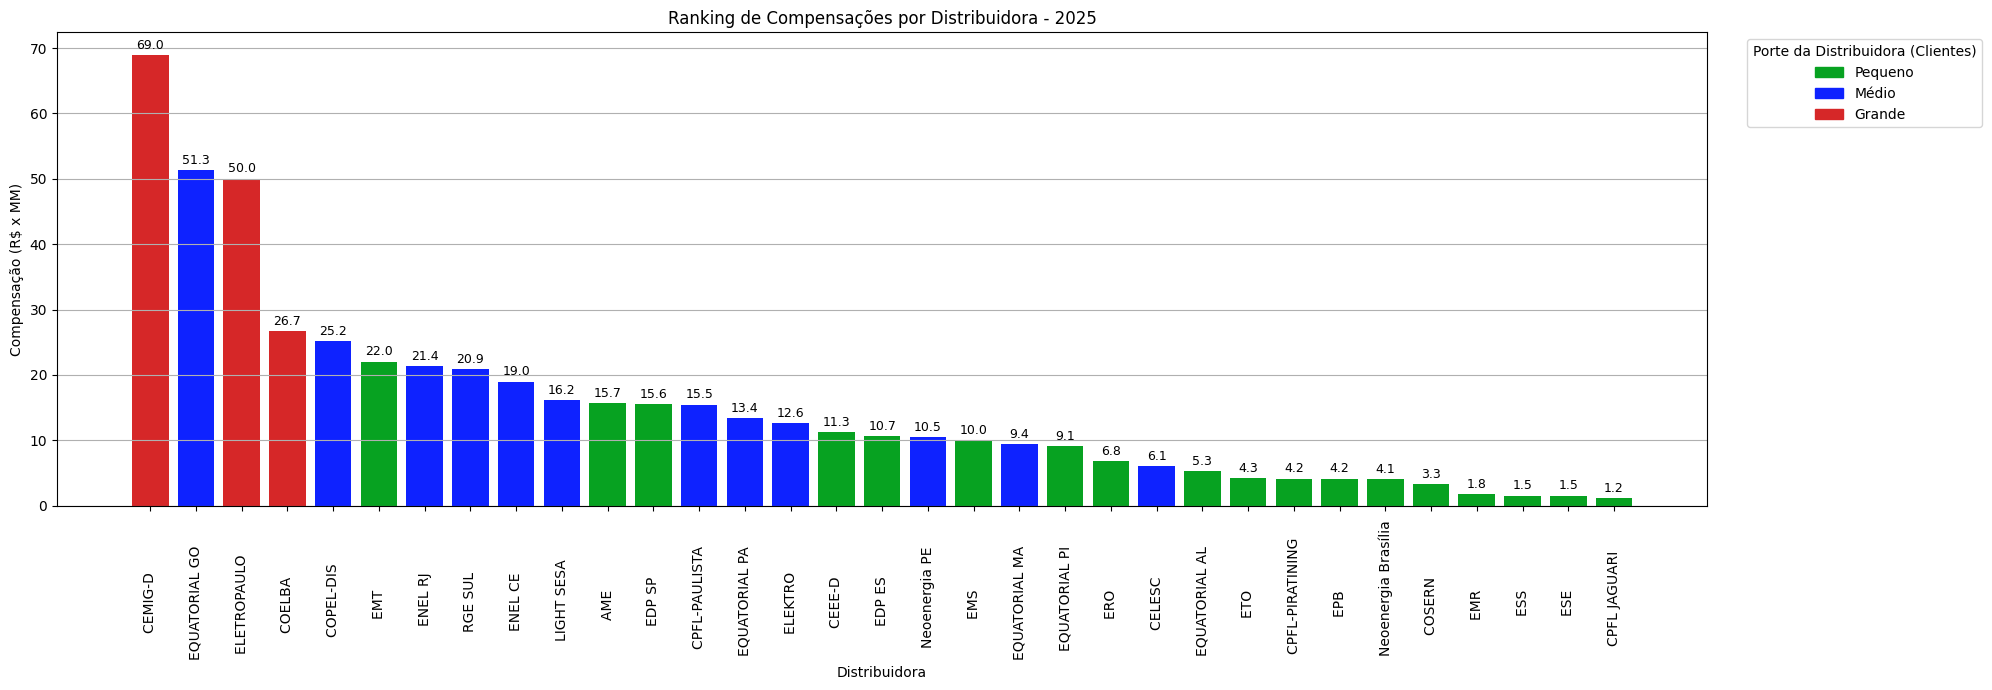

In [204]:
# ! Pagamento das distribuidoras em 2025:
## Montagem do novo dataframe:
dfGraph = dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'DINHEIRO')][['SIGAGENTE','VLRINDICEENVIADO','NUC_CATEGORIA']].groupby(by=['SIGAGENTE','NUC_CATEGORIA'])['VLRINDICEENVIADO'].sum().reset_index()
dfGraph['VLRINDICEENVIADO'] = dfGraph['VLRINDICEENVIADO']/1000000

# Gráfico:
plt.subplots(figsize=(20,7))
plt.grid()
# Ajustes de gráficos  
ax=sns.barplot(x="SIGAGENTE", y="VLRINDICEENVIADO", data=dfGraph,color="black", order=dfGraph.sort_values('VLRINDICEENVIADO', ascending=False)['SIGAGENTE'])
ax.set(xlabel='Distribuidora', ylabel='Compensação (R$ x MM)', title='Ranking de Compensações por Distribuidora - 2025')
plt.xticks(rotation=90)
# Plotar rótulos:
for i, bar in enumerate(ax.patches):
    valor = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    y_pos = valor + 0.5  # Ajuste vertical
    ax.text(x_pos, y_pos, f'{valor:.1f}', ha='center', va='bottom', fontsize=9)

# Colorir os gráficos:
for i, row in dfGraph.iterrows():
    sigagente = row['SIGAGENTE']
    valor = row['VLRINDICEENVIADO']
    categoria = row['NUC_CATEGORIA']
    cor = cores_nuc.get(categoria, 'gray')
    ax.bar(sigagente, valor, color=cor)

# Legenda:
legenda_patches = [Patch(color=cor, label=cat) for cat, cor in cores_nuc.items()]
ax.legend(handles=legenda_patches, title='Porte da Distribuidora (Clientes)', bbox_to_anchor=(1.02, 1), loc='upper left')

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-ranking-2025.png'))

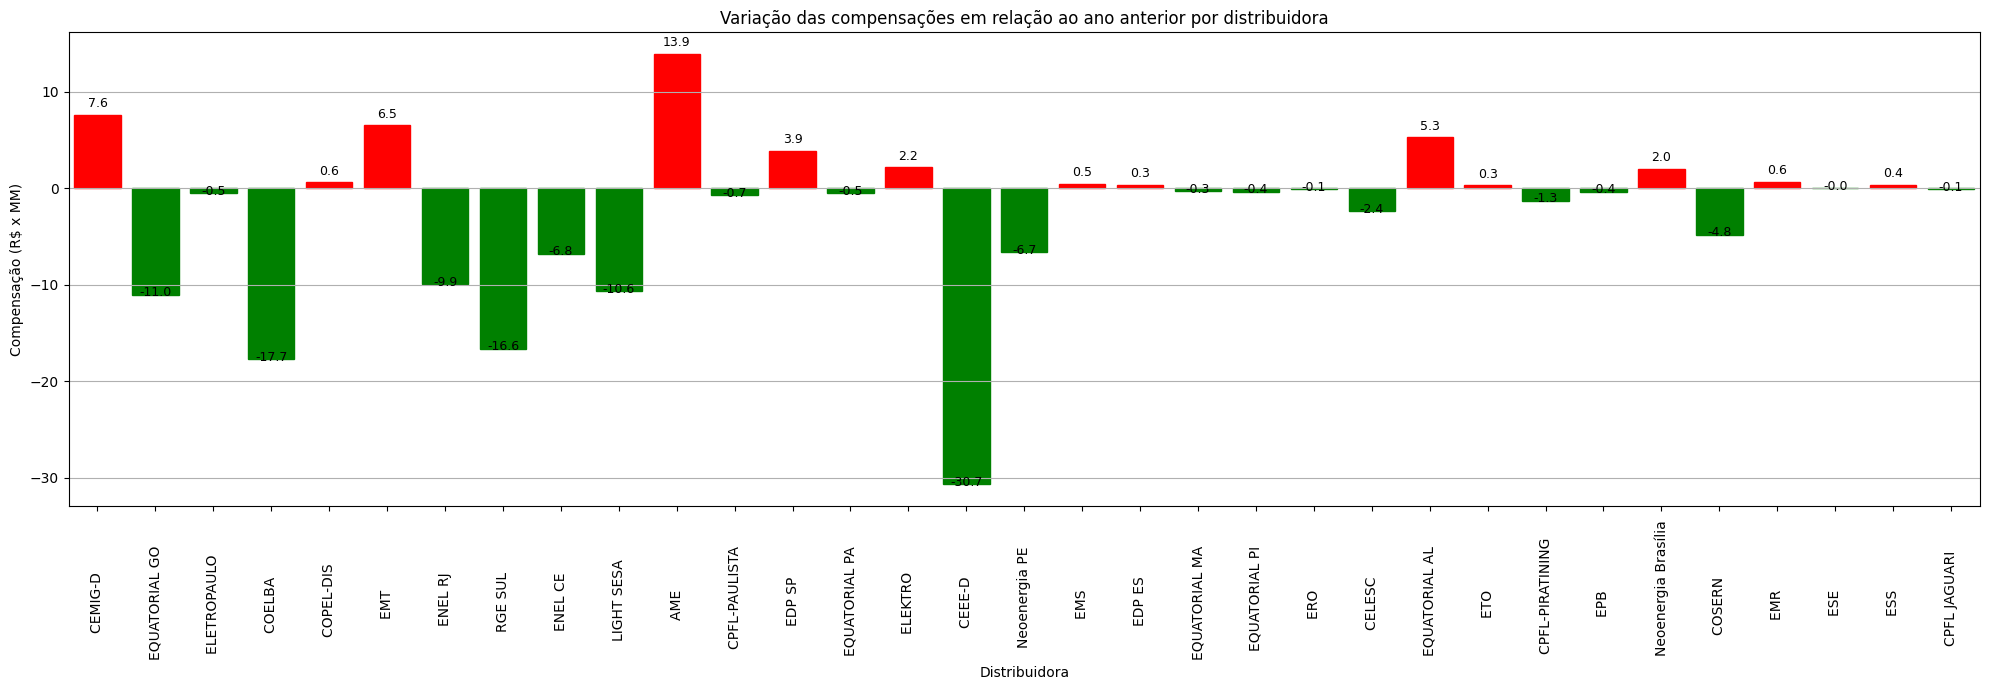

In [ ]:
# ! Variação das distribuidoras entre 2024 e 2025:
## Montagem do novo dataframe:
dfGraph = pd.merge(dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'DINHEIRO') & (dfCompT['NUMPERIODOINDICE'] <= 6 )][['SIGAGENTE','VLRINDICEENVIADO']].groupby(by='SIGAGENTE')['VLRINDICEENVIADO'].sum().reset_index(),
                    dfCompT[(dfCompT['ANOINDICE'] == 2024) & (dfCompT['INDICADOR'] == 'DINHEIRO') & (dfCompT['NUMPERIODOINDICE'] <= 6 )][['SIGAGENTE','VLRINDICEENVIADO']].groupby(by='SIGAGENTE')['VLRINDICEENVIADO'].sum().reset_index(),
                    how = 'left',
                    on = 'SIGAGENTE')
dfGraph = dfGraph.rename(columns={'VLRINDICEENVIADO_x':'VALOR_2025', 'VLRINDICEENVIADO_y':'VALOR_2024'})
dfGraph['DELTA'] = dfGraph['VALOR_2025'] - dfGraph['VALOR_2024']
dfGraph['DELTA_MM'] = dfGraph['DELTA']/1000000

# Gráfico:
plt.subplots(figsize=(20,7))
plt.grid()
# Ajustes de gráficos  
ax=sns.barplot(x="SIGAGENTE", y="DELTA_MM", data=dfGraph,color="black", order=dfGraph.sort_values('VALOR_2025', ascending=False)['SIGAGENTE'])
ax.set(xlabel='Distribuidora', ylabel='Compensação (R$ x MM)', title='Variação das compensações em relação ao ano anterior por distribuidora')
plt.xticks(rotation=90)
# Plotar rótulos:
for i, bar in enumerate(ax.patches):
    valor = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    if valor >= 0:
        y_pos = valor + 0.5
        bar.set_color('red')  # Positivos em vermelho
    else:
        y_pos = valor - 0.5
        bar.set_color('green')  # Negativos em verde

    ax.text(x_pos, y_pos, f'{valor:.1f}', ha='center', va='bottom', fontsize=9)

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-ranking-2025-variacao-2024.png'))

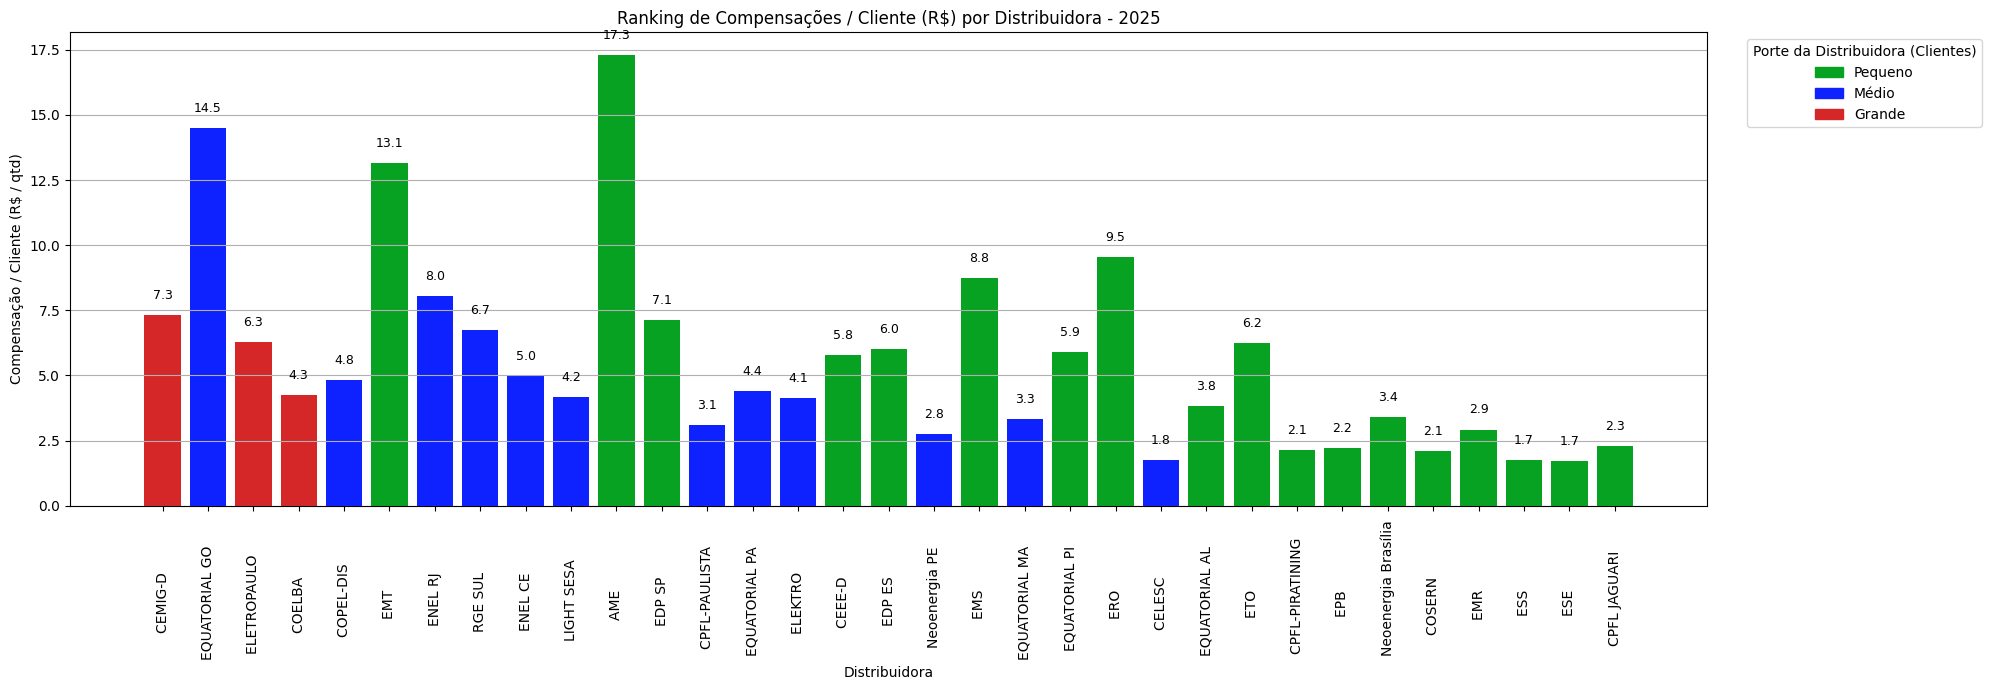

In [210]:
# ! Pagamento das distribuidoras em 2025 - Montante por cliente:
## Montagem do novo dataframe:
dfGraph = dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'DINHEIRO')][['SIGAGENTE','VLRINDICEENVIADO','NUC','NUC_CATEGORIA']].groupby(by=['SIGAGENTE','NUC','NUC_CATEGORIA'])['VLRINDICEENVIADO'].sum().reset_index()
dfGraph['COMP_CLIENTE'] = dfGraph['VLRINDICEENVIADO']/dfGraph['NUC']

# Gráfico:
plt.subplots(figsize=(20,7))
plt.grid()
# Ajustes de gráficos  
ax=sns.barplot(x="SIGAGENTE", y="COMP_CLIENTE", data=dfGraph,color="black", order=dfGraph.sort_values('VLRINDICEENVIADO', ascending=False)['SIGAGENTE'])
ax.set(xlabel='Distribuidora', ylabel='Compensação / Cliente (R$ / qtd)', title='Ranking de Compensações / Cliente (R$) por Distribuidora - 2025')
plt.xticks(rotation=90)
# Plotar rótulos:
for i, bar in enumerate(ax.patches):
    valor = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    y_pos = valor + 0.5  # Ajuste vertical
    ax.text(x_pos, y_pos, f'{valor:.1f}', ha='center', va='bottom', fontsize=9)

# Colorir os gráficos:
for i, row in dfGraph.iterrows():
    sigagente = row['SIGAGENTE']
    valor = row['COMP_CLIENTE']
    categoria = row['NUC_CATEGORIA']
    cor = cores_nuc.get(categoria, 'gray')
    ax.bar(sigagente, valor, color=cor)

# Legenda:
legenda_patches = [Patch(color=cor, label=cat) for cat, cor in cores_nuc.items()]
ax.legend(handles=legenda_patches, title='Porte da Distribuidora (Clientes)', bbox_to_anchor=(1.02, 1), loc='upper left')

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-valor-por-cliente-2025.png'))

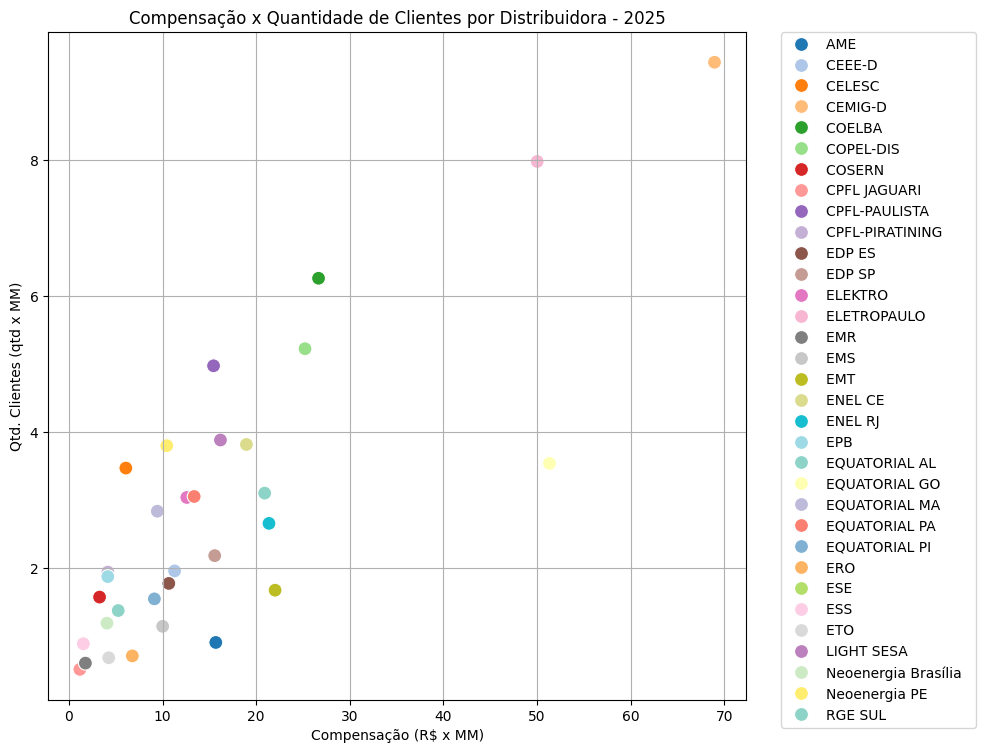

In [110]:
# Gráfico:
plt.subplots(figsize=(10,8))
plt.grid()
# Ajustes de gráficos:
palette = sns.color_palette("tab20", 20) + sns.color_palette("Set3", 13)
ax=sns.scatterplot(y=dfGraph["NUC"]/1000000, x=dfGraph["VLRINDICEENVIADO"]/1000000, data=dfGraph, hue='SIGAGENTE', palette=palette, s=100)
ax.set(ylabel='Qtd. Clientes (qtd x MM)', xlabel='Compensação (R$ x MM)', title='Compensação x Quantidade de Clientes por Distribuidora - 2025')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-valor-qtd-clientes-disco-2025.png'))

In [114]:
dfCompT.head()

,SIGAGENTE,IDECONJUNDCONSUMIDORAS,SIGINDICADOR,ANOINDICE,NUMPERIODOINDICE,VLRINDICEENVIADO,DSCINDICADOR,INDICADOR,TENSAO,GERACAO,URBANO,NUC
2,ETO,13621,QTUCBTUDC,2020,8,0.0,Qtde de UCs BT urbanas comp por violacao dos limites de DICRI,CLIENTES,BT,0.0,1.0,681872.0
3,ETO,13638,QTUCATT,2020,1,0.0,Qtde de UCs AT compens por violacao dos limites de cont no trimestre,CLIENTES,AT,0.0,NaN,681872.0
4,ETO,16028,QTUCMTUT,2020,3,0.0,Qtde de UCs MT urbanas compens por violacao dos limites de cont no trimestre,CLIENTES,MT,0.0,1.0,681872.0
5,ETO,16034,PGUCMTNUT,2020,3,0.0,Valor pago a UCs MT não urbanas por violacao dos limites de cont no trimestre,DINHEIRO,MT,0.0,0.0,681872.0
6,ETO,13621,QTUCBTNUDC,2020,11,3.0,Qtde de UCs BT não urbanas comp por violacao dos limites de DICRI,CLIENTES,BT,0.0,0.0,681872.0


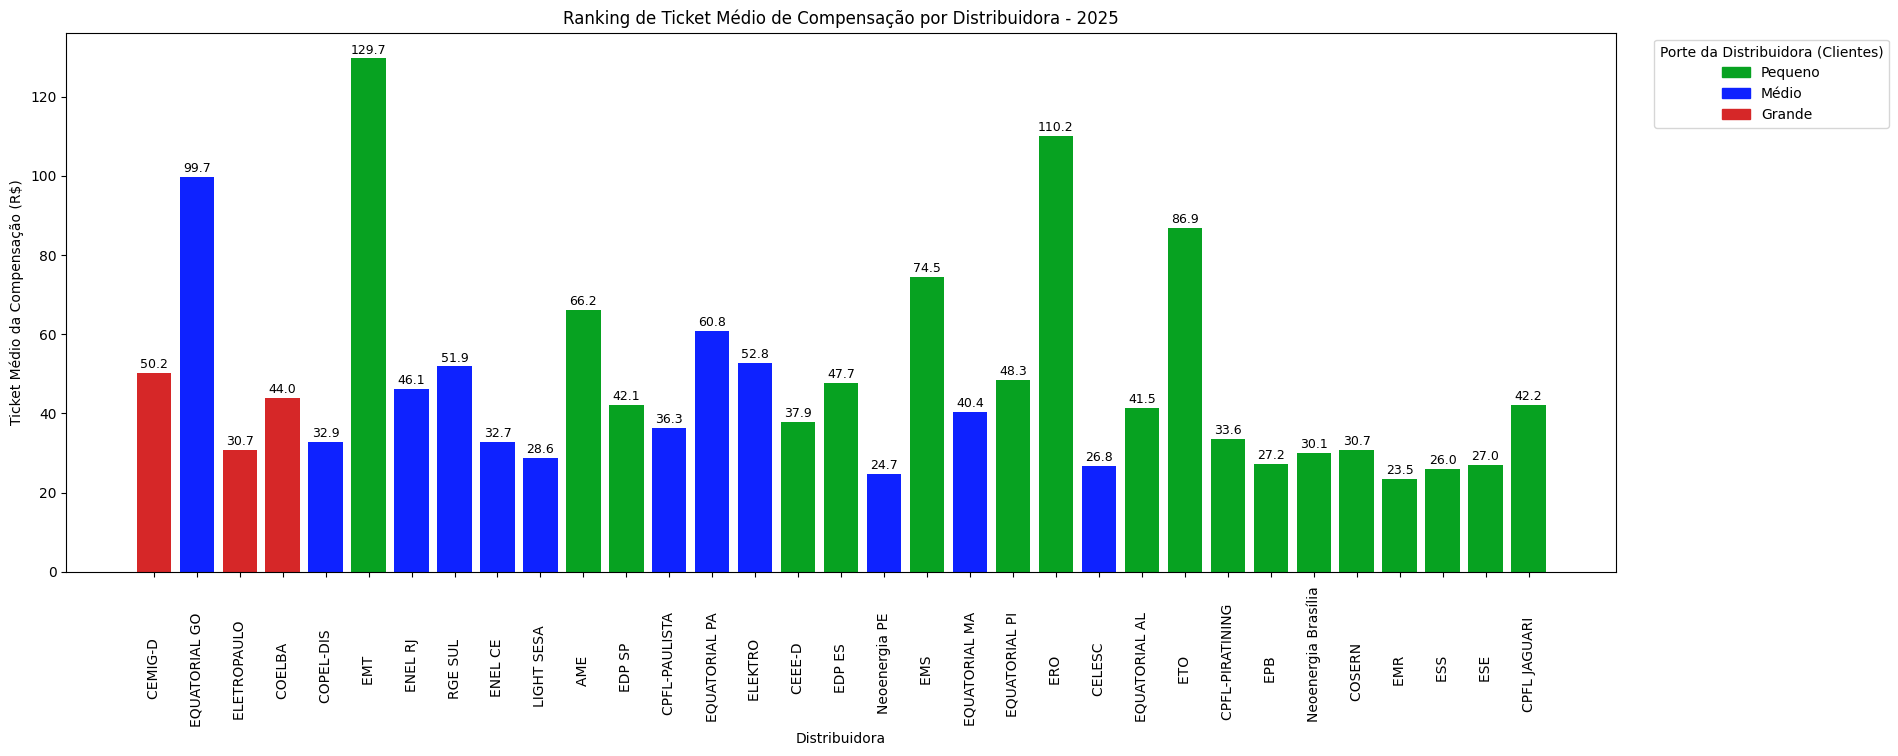

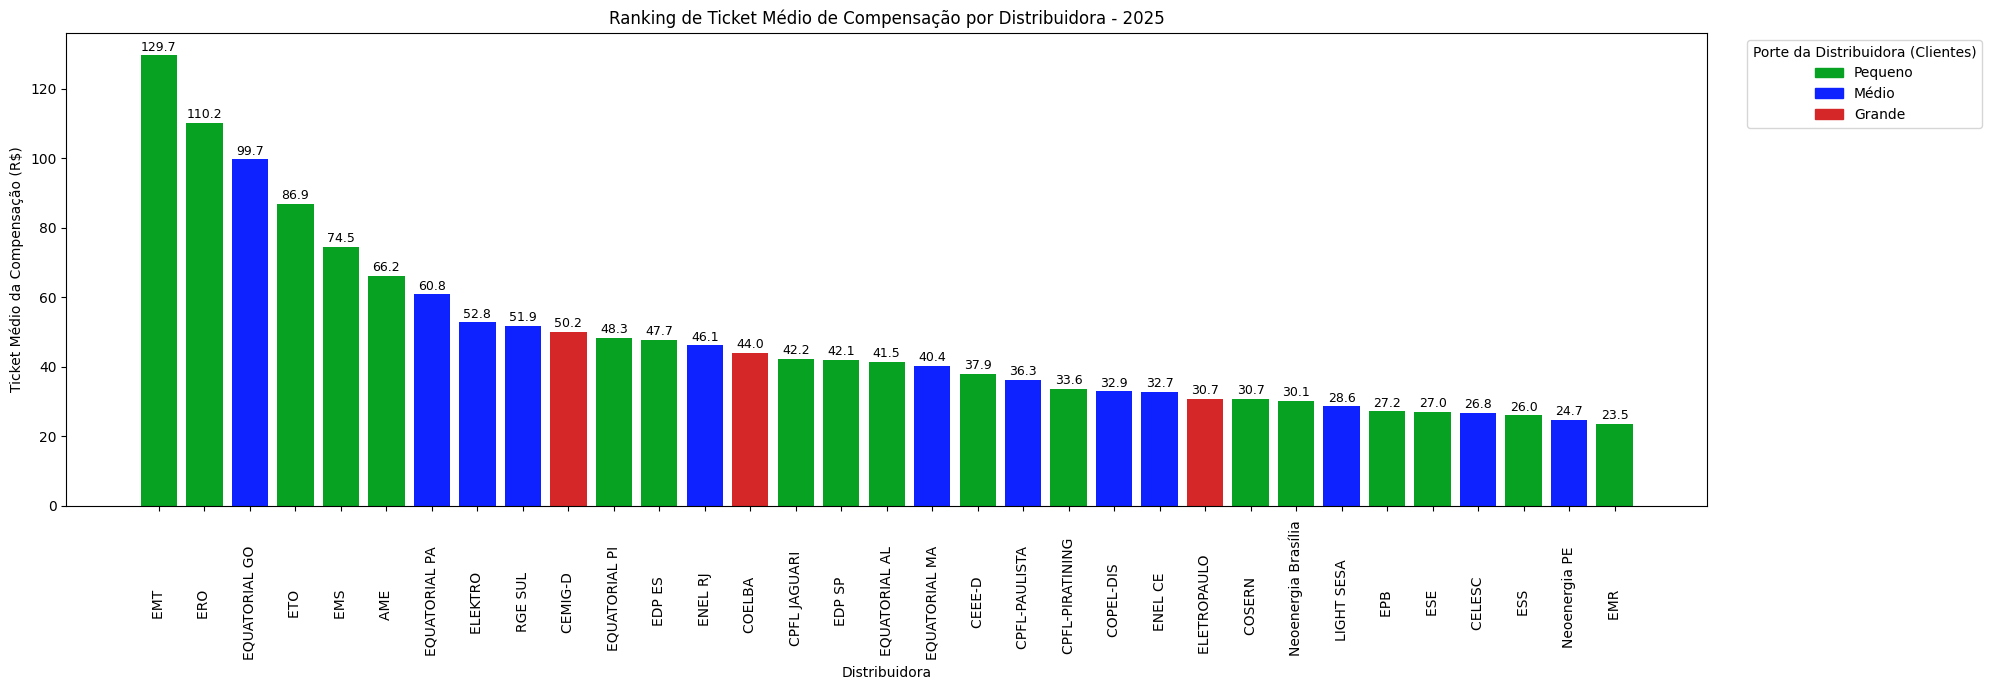

In [215]:
# ! Ticket Médio por Distribuidora:
# Montagem do novo dataframe:
dfGraph = pd.merge(dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'DINHEIRO')][['SIGAGENTE','VLRINDICEENVIADO','NUC','NUC_CATEGORIA']].groupby(by=['SIGAGENTE','NUC','NUC_CATEGORIA'])['VLRINDICEENVIADO'].sum().reset_index(),
                   dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'CLIENTES')][['SIGAGENTE','VLRINDICEENVIADO']].groupby(by=['SIGAGENTE'])['VLRINDICEENVIADO'].sum().reset_index(),
                   how = 'left',
                   on = 'SIGAGENTE')
dfGraph = dfGraph.rename(columns={'VLRINDICEENVIADO_x':'VALOR', 'VLRINDICEENVIADO_y':'CLIENTES'})
dfGraph = dfGraph[['SIGAGENTE','VALOR','CLIENTES','NUC_CATEGORIA']]
dfGraph['TICKET_MEDIO'] = dfGraph['VALOR'] / dfGraph['CLIENTES']

# Gráfico:
plt.subplots(figsize=(20,7))
# Ajustes de gráficos  
ax=sns.barplot(x="SIGAGENTE", y="TICKET_MEDIO", data=dfGraph,color="black", order=dfGraph.sort_values('VALOR', ascending=False)['SIGAGENTE'])
ax.set(xlabel='Distribuidora', ylabel='Ticket Médio da Compensação (R$)', title='Ranking de Ticket Médio de Compensação por Distribuidora - 2025')
plt.xticks(rotation=90)
# Plotar rótulos:
for i, bar in enumerate(ax.patches):
    valor = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    y_pos = valor + 0.5  # Ajuste vertical
    ax.text(x_pos, y_pos, f'{valor:.1f}', ha='center', va='bottom', fontsize=9)

# Colorir os gráficos:
for i, row in dfGraph.iterrows():
    sigagente = row['SIGAGENTE']
    valor = row['TICKET_MEDIO']
    categoria = row['NUC_CATEGORIA']
    cor = cores_nuc.get(categoria, 'gray')
    ax.bar(sigagente, valor, color=cor)

# Legenda:
legenda_patches = [Patch(color=cor, label=cat) for cat, cor in cores_nuc.items()]
ax.legend(handles=legenda_patches, title='Porte da Distribuidora (Clientes)', bbox_to_anchor=(1.02, 1), loc='upper left')

# Gráfico:
plt.subplots(figsize=(20,7))
# Ajustes de gráficos  
ax=sns.barplot(x="SIGAGENTE", y="TICKET_MEDIO", data=dfGraph,color="black", order=dfGraph.sort_values('TICKET_MEDIO', ascending=False)['SIGAGENTE'])
ax.set(xlabel='Distribuidora', ylabel='Ticket Médio da Compensação (R$)', title='Ranking de Ticket Médio de Compensação por Distribuidora - 2025')
plt.xticks(rotation=90)
# Plotar rótulos:
for i, bar in enumerate(ax.patches):
    valor = bar.get_height()
    x_pos = bar.get_x() + bar.get_width() / 2
    y_pos = valor + 0.5  # Ajuste vertical
    ax.text(x_pos, y_pos, f'{valor:.1f}', ha='center', va='bottom', fontsize=9)

# Colorir os gráficos:
for i, row in dfGraph.iterrows():
    sigagente = row['SIGAGENTE']
    valor = row['TICKET_MEDIO']
    categoria = row['NUC_CATEGORIA']
    cor = cores_nuc.get(categoria, 'gray')
    ax.bar(sigagente, valor, color=cor)

# Legenda:
legenda_patches = [Patch(color=cor, label=cat) for cat, cor in cores_nuc.items()]
ax.legend(handles=legenda_patches, title='Porte da Distribuidora (Clientes)', bbox_to_anchor=(1.02, 1), loc='upper left')

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-ranking-ticket-medio-2025.png'))

In [140]:
dfGraph.head(10)

,SIGAGENTE,NUC,VLRINDICEENVIADO,PERC_COMPENSADO,NUC_CATEGORIA
0,AME,906769.0,236881.0,0.261236,Até 1 MM
1,CEEE-D,1957930.0,297836.0,0.152118,"Até 2,5 MM"
2,CELESC,3469262.0,227138.0,0.065472,Até 4 MM
3,CEMIG-D,9431438.0,1374719.0,0.145759,Acima 4 MM
4,COELBA,6257879.0,606242.0,0.096877,Acima 4 MM
5,COPEL-DIS,5222652.0,766810.0,0.146824,Acima 4 MM
6,COSERN,1573660.0,106780.0,0.067855,"Até 2,5 MM"
7,CPFL JAGUARI,511567.0,27829.0,0.054400,Até 1 MM
8,CPFL-PAULISTA,4971797.0,426038.0,0.085691,Acima 4 MM
9,CPFL-PIRATINING,1940801.0,123701.0,0.063737,"Até 2,5 MM"


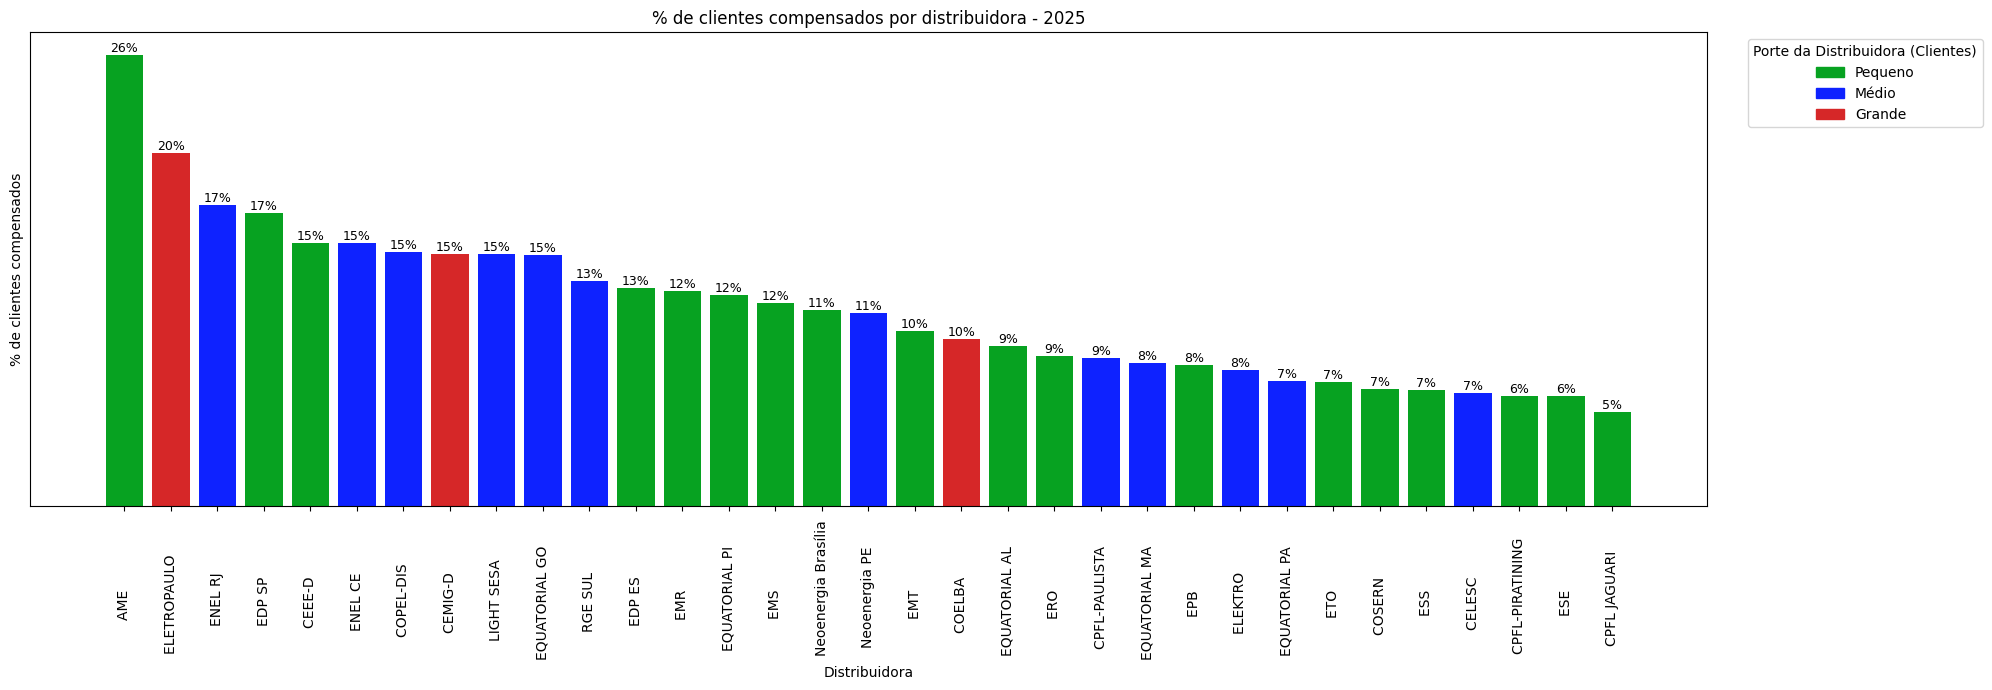

In [217]:
# ! Clientes compensados sobre o total:
## Montagem do novo dataframe:
dfGraph = dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'CLIENTES')][['SIGAGENTE','VLRINDICEENVIADO','NUC','NUC_CATEGORIA']].groupby(by=['SIGAGENTE','NUC','NUC_CATEGORIA'])['VLRINDICEENVIADO'].sum().reset_index()
dfGraph['PERC_COMPENSADO'] = dfGraph['VLRINDICEENVIADO']/dfGraph['NUC']

# Gráfico:
plt.subplots(figsize=(20,7))
plt.grid()
# Ajustes de gráficos:
ax=sns.barplot(x="SIGAGENTE", y="PERC_COMPENSADO", data=dfGraph,color="black", order=dfGraph.sort_values('PERC_COMPENSADO', ascending=False)['SIGAGENTE'])
ax.set(xlabel='Distribuidora', ylabel='% de clientes compensados', title='% de clientes compensados por distribuidora - 2025')
plt.xticks(rotation=90)
ax.yaxis.set_ticks([])
# Colorir os gráficos:
for i, row in dfGraph.iterrows():
    sigagente = row['SIGAGENTE']
    valor = row['PERC_COMPENSADO']
    categoria = row['NUC_CATEGORIA']
    cor = cores_nuc.get(categoria, 'gray')
    ax.bar(sigagente, valor, color=cor)
    # Rótulo:
    ax.text(sigagente, valor, f'{valor*100:.0f}%', ha='center', va='bottom', fontsize=9)

# Legenda:
legenda_patches = [Patch(color=cor, label=cat) for cat, cor in cores_nuc.items()]
ax.legend(handles=legenda_patches, title='Porte da Distribuidora (Clientes)', bbox_to_anchor=(1.02, 1), loc='upper left')

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-percentual-clientes-compensados-disco-2025.png'))

In [240]:
# ! Análise de clientes compensados:
# Montagem do novo dataframe:
dfGraph = pd.merge(dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'CLIENTES')][['SIGAGENTE','VLRINDICEENVIADO','NUC','NUC_CATEGORIA','TENSAO']].groupby(by=['SIGAGENTE','NUC','NUC_CATEGORIA','TENSAO'])['VLRINDICEENVIADO'].sum().reset_index(),
                   dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'CLIENTES')][['SIGAGENTE','VLRINDICEENVIADO']].groupby(by=['SIGAGENTE'])['VLRINDICEENVIADO'].sum().reset_index(),
                   how = 'left',
                    on = 'SIGAGENTE')
dfGraph = dfGraph.rename(columns={'VLRINDICEENVIADO_x':'CLIENTES_TENSAO','VLRINDICEENVIADO_y':'TOTAL_CLIENTES_COMPENSADOS'})
dfGraph['PERC_CLIENTES'] = dfGraph['CLIENTES_TENSAO']/dfGraph['TOTAL_CLIENTES_COMPENSADOS']

# Análise:
dfGraph[dfGraph['NUC_CATEGORIA'] == 'Grande'][['SIGAGENTE','TENSAO','PERC_CLIENTES']].assign(PERC_CLIENTES=lambda x: x['PERC_CLIENTES'].apply(lambda v: f'{v*100:.1f}%'))

,SIGAGENTE,TENSAO,PERC_CLIENTES
9,CEMIG-D,AT,0.0%
10,CEMIG-D,BT,99.7%
11,CEMIG-D,MT,0.3%
12,COELBA,AT,0.0%
13,COELBA,BT,99.4%
14,COELBA,MT,0.6%
39,ELETROPAULO,AT,0.0%
40,ELETROPAULO,BT,99.8%
41,ELETROPAULO,MT,0.2%


In [ ]:
# ! Análise de clientes compensados por Nível de Tensão:
# Montagem do novo dataframe:
dfGraph = pd.merge(dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'CLIENTES')][['SIGAGENTE','VLRINDICEENVIADO','NUC','NUC_CATEGORIA','TENSAO']].groupby(by=['SIGAGENTE','NUC','NUC_CATEGORIA','TENSAO'])['VLRINDICEENVIADO'].sum().reset_index(),
                   dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'DINHEIRO')][['SIGAGENTE','VLRINDICEENVIADO','TENSAO']].groupby(by=['SIGAGENTE','TENSAO'])['VLRINDICEENVIADO'].sum().reset_index(),
                   how = 'left',
                    on = ['SIGAGENTE','TENSAO'])
dfGraph = dfGraph.rename(columns={'VLRINDICEENVIADO_x':'CLIENTES','VLRINDICEENVIADO_y':'VALOR'})
dfGraph['TICKET'] = dfGraph['VALOR']/dfGraph['CLIENTES']

# Análise:
dfGraph[dfGraph['NUC_CATEGORIA'] == 'Grande'].assign(
    CLIENTES=lambda x: x['CLIENTES'].apply(lambda v: f'{v:,.0f}'),
    VALOR=lambda x: x['VALOR'].apply(lambda v: f'{v:,.2f}'),
    TICKET=lambda x: x['TICKET'].apply(lambda v: f'{v:,.2f}'),
    ).sort_values(by='TENSAO')[['SIGAGENTE','TENSAO','CLIENTES','VALOR','TICKET']]

,SIGAGENTE,TENSAO,CLIENTES,VALOR,TICKET
9,CEMIG-D,AT,5,"548,213.25","109,642.65"
12,COELBA,AT,3,"222,989.19","74,329.73"
39,ELETROPAULO,AT,1,"4,138.48","4,138.48"
10,CEMIG-D,BT,"1,371,121","49,663,107.77",36.22
13,COELBA,BT,"602,614","20,474,239.66",33.98
40,ELETROPAULO,BT,"1,624,662","41,843,238.93",25.76
11,CEMIG-D,MT,"3,593","18,745,945.91","5,217.35"
14,COELBA,MT,"3,625","5,967,664.30","1,646.25"
41,ELETROPAULO,MT,"3,602","8,172,446.23","2,268.86"


C:\Users\bella\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


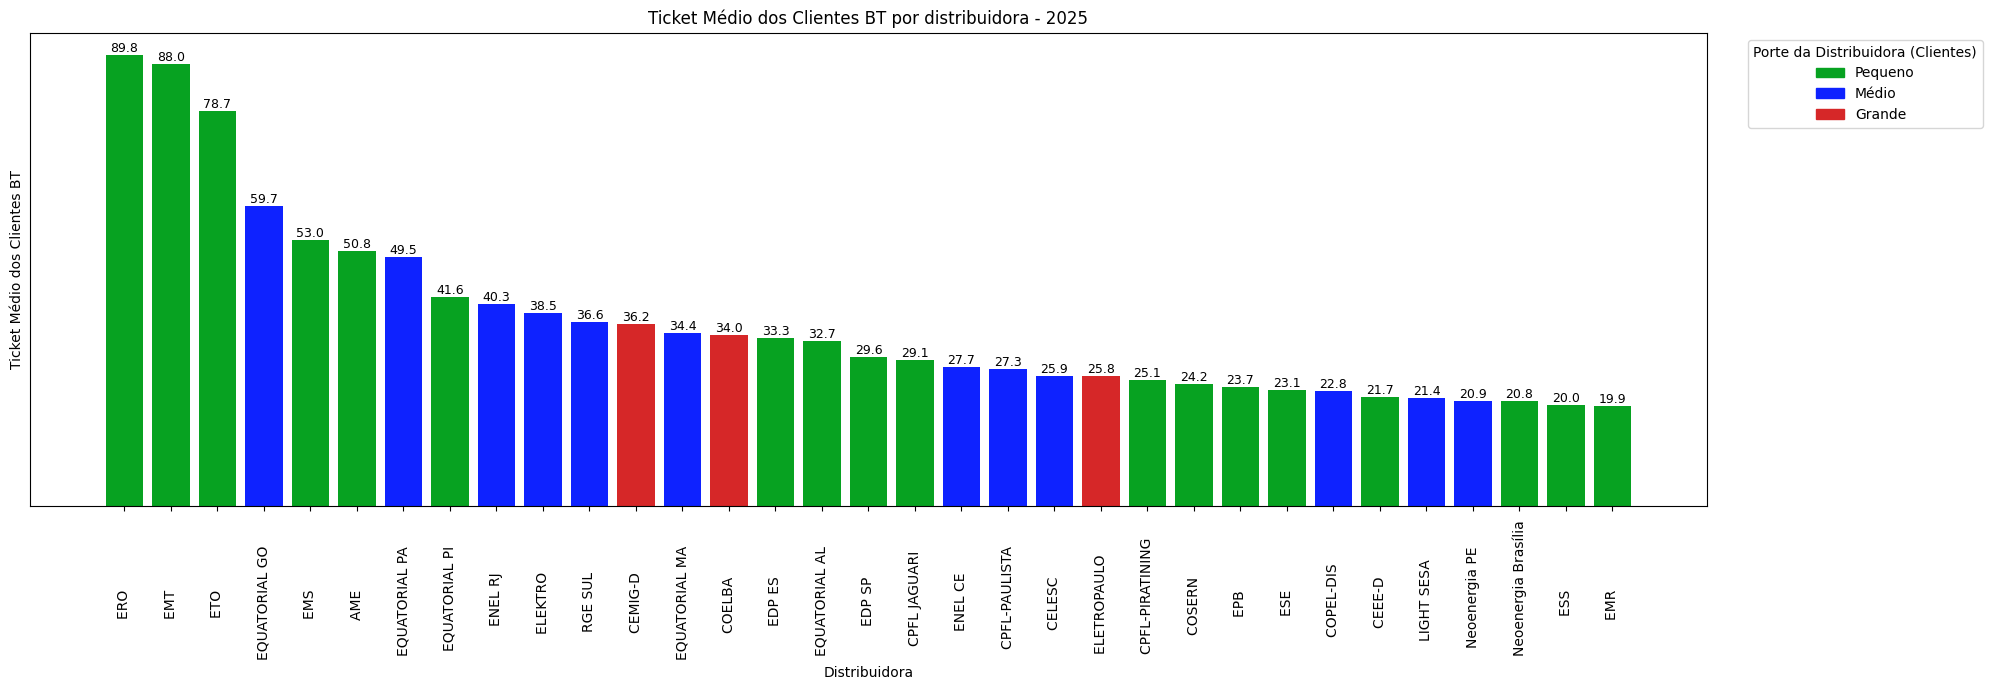

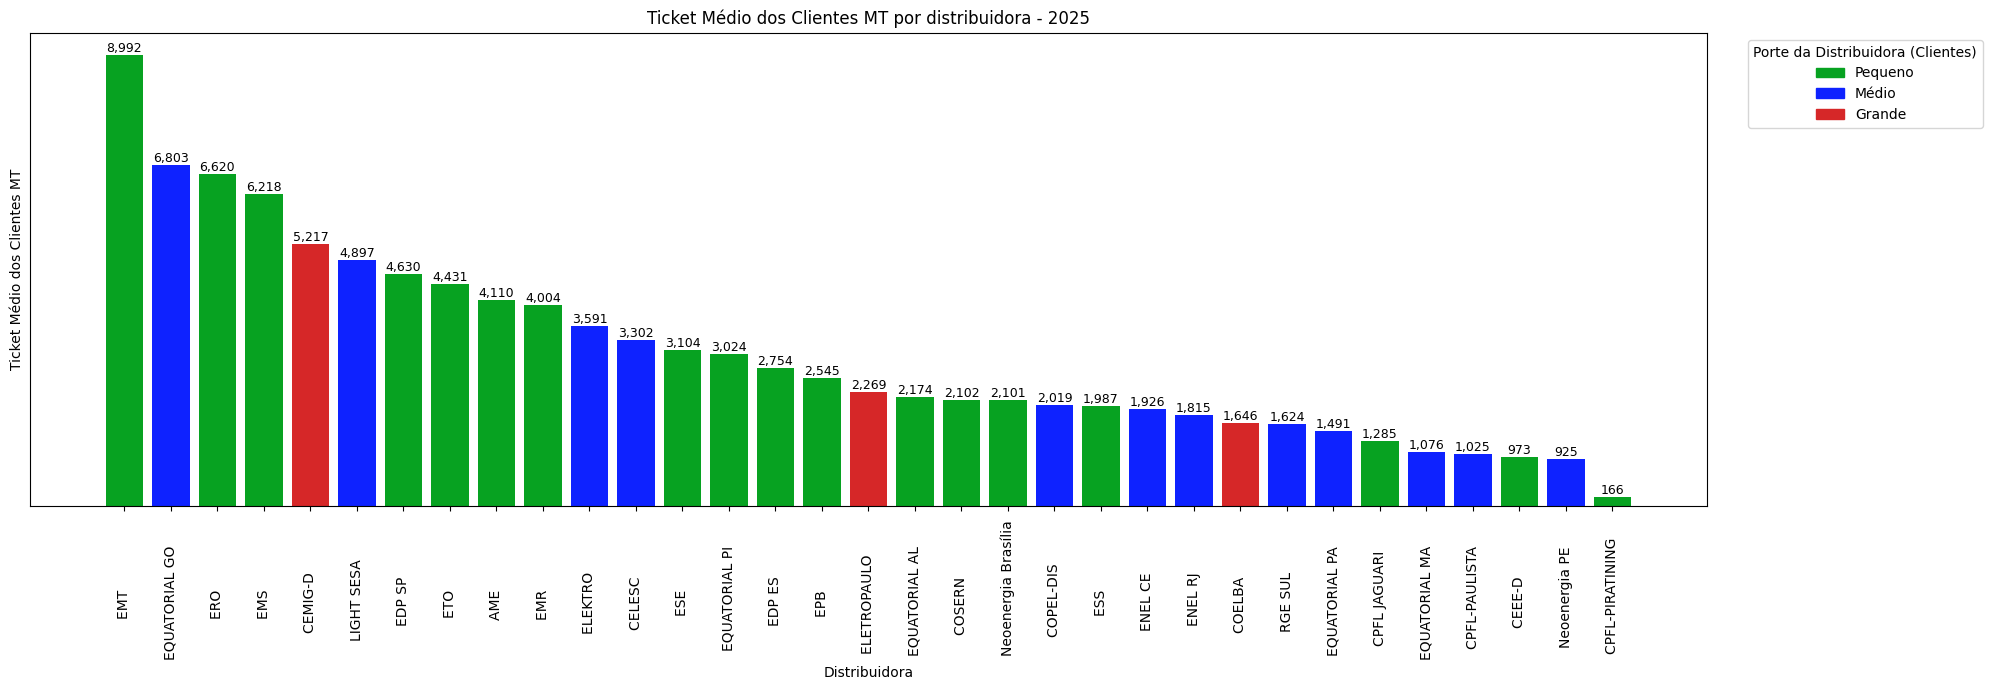

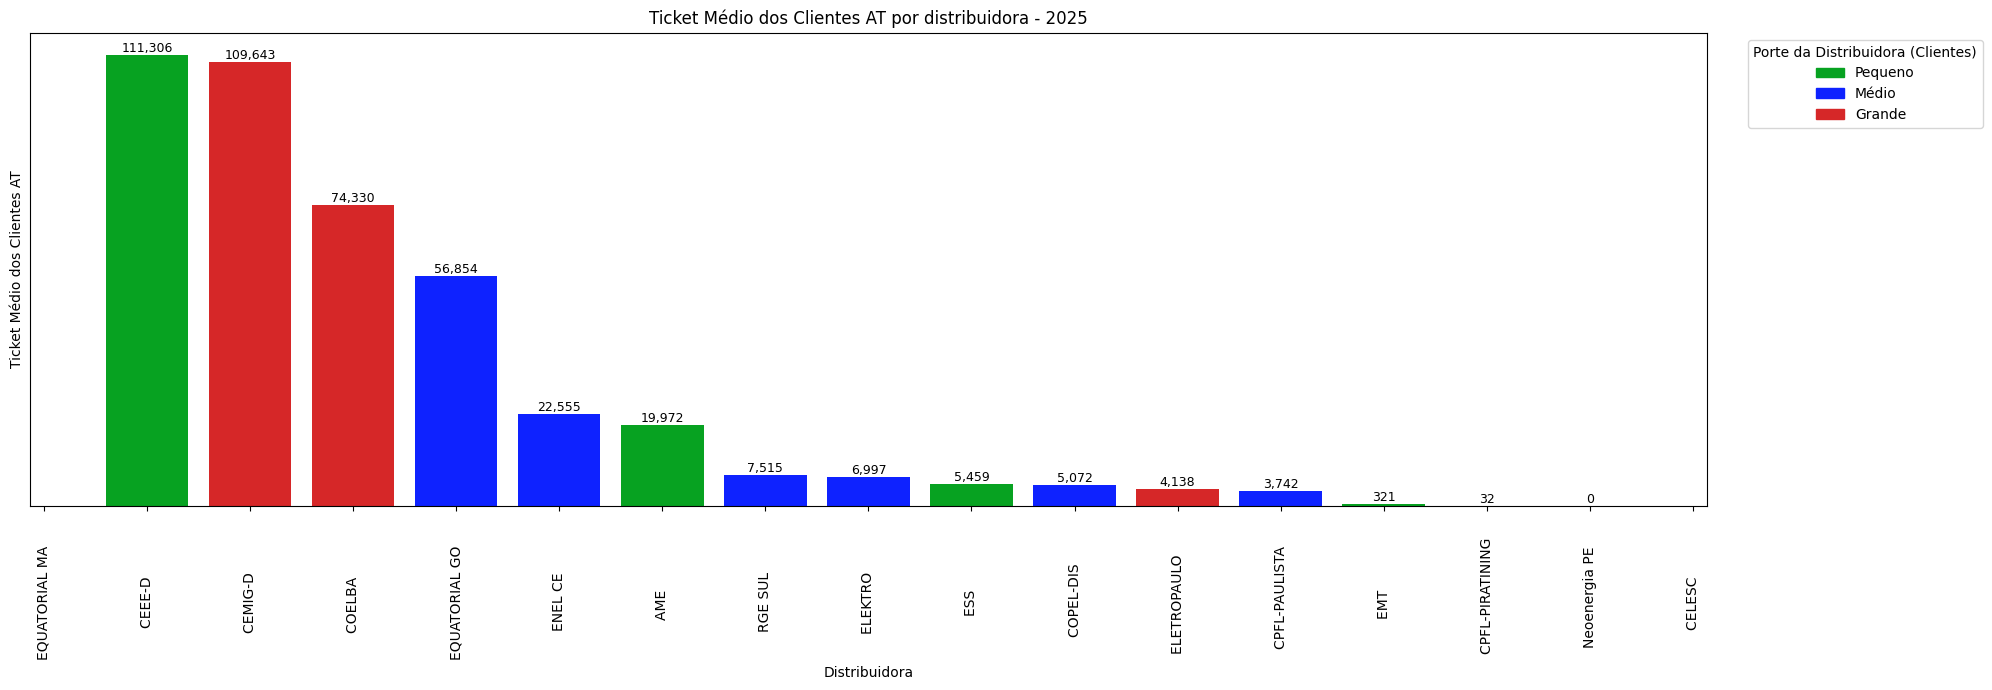

In [308]:
# Montagem do novo dataframe:
dfGraph = pd.merge(dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'CLIENTES')][['SIGAGENTE','VLRINDICEENVIADO','NUC','NUC_CATEGORIA','TENSAO']].groupby(by=['SIGAGENTE','NUC','NUC_CATEGORIA','TENSAO'])['VLRINDICEENVIADO'].sum().reset_index(),
                   dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'DINHEIRO')][['SIGAGENTE','VLRINDICEENVIADO','TENSAO']].groupby(by=['SIGAGENTE','TENSAO'])['VLRINDICEENVIADO'].sum().reset_index(),
                   how = 'left',
                    on = ['SIGAGENTE','TENSAO'])
dfGraph = dfGraph.rename(columns={'VLRINDICEENVIADO_x':'CLIENTES','VLRINDICEENVIADO_y':'VALOR'})
dfGraph['TICKET'] = dfGraph['VALOR']/dfGraph['CLIENTES']

# Gráfico - BT:
plt.subplots(figsize=(20,7))
plt.grid()
# Ajustes de gráficos:
ax=sns.barplot(x="SIGAGENTE", y="TICKET", 
               data = dfGraph[dfGraph['TENSAO'] == 'BT'] ,
               color="black", order = dfGraph[dfGraph['TENSAO'] == 'BT'].sort_values('TICKET', ascending=False)['SIGAGENTE'])
ax.set(xlabel='Distribuidora', ylabel='Ticket Médio dos Clientes BT', title='Ticket Médio dos Clientes BT por distribuidora - 2025')
plt.xticks(rotation=90)
ax.yaxis.set_ticks([])
# Colorir os gráficos:
for i, row in dfGraph[dfGraph['TENSAO'] == 'BT'].iterrows():
    sigagente = row['SIGAGENTE']
    valor = row['TICKET']
    categoria = row['NUC_CATEGORIA']
    cor = cores_nuc.get(categoria, 'gray')
    ax.bar(sigagente, valor, color=cor)
    # Rótulo:
    ax.text(sigagente, valor, f'{valor:,.1f}', ha='center', va='bottom', fontsize=9)

# Legenda:
legenda_patches = [Patch(color=cor, label=cat) for cat, cor in cores_nuc.items()]
ax.legend(handles=legenda_patches, title='Porte da Distribuidora (Clientes)', bbox_to_anchor=(1.02, 1), loc='upper left')

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-ticket-medio-clientes-bt.png'))

# Gráfico - MT:
plt.subplots(figsize=(20,7))
plt.grid()
# Ajustes de gráficos:
ax=sns.barplot(x="SIGAGENTE", y="TICKET", 
               data = dfGraph[dfGraph['TENSAO'] == 'MT'] ,
               color="black", order = dfGraph[dfGraph['TENSAO'] == 'MT'].sort_values('TICKET', ascending=False)['SIGAGENTE'])
ax.set(xlabel='Distribuidora', ylabel='Ticket Médio dos Clientes MT', title='Ticket Médio dos Clientes MT por distribuidora - 2025')
plt.xticks(rotation=90)
ax.yaxis.set_ticks([])
# Colorir os gráficos:
for i, row in dfGraph[dfGraph['TENSAO'] == 'MT'].iterrows():
    sigagente = row['SIGAGENTE']
    valor = row['TICKET']
    categoria = row['NUC_CATEGORIA']
    cor = cores_nuc.get(categoria, 'gray')
    ax.bar(sigagente, valor, color=cor)
    # Rótulo:
    ax.text(sigagente, valor, f'{valor:,.0f}', ha='center', va='bottom', fontsize=9)

# Legenda:
legenda_patches = [Patch(color=cor, label=cat) for cat, cor in cores_nuc.items()]
ax.legend(handles=legenda_patches, title='Porte da Distribuidora (Clientes)', bbox_to_anchor=(1.02, 1), loc='upper left')

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-ticket-medio-clientes-mt.png'))

# Gráfico - AT:
plt.subplots(figsize=(20,7))
plt.grid()
# Ajustes de gráficos:
ax=sns.barplot(x="SIGAGENTE", y="TICKET", 
               data = dfGraph[dfGraph['TENSAO'] == 'AT'] ,
               color="black", order = dfGraph[dfGraph['TENSAO'] == 'AT'].sort_values('TICKET', ascending=False)['SIGAGENTE'])
ax.set(xlabel='Distribuidora', ylabel='Ticket Médio dos Clientes AT', title='Ticket Médio dos Clientes AT por distribuidora - 2025')
plt.xticks(rotation=90)
ax.yaxis.set_ticks([])
# Colorir os gráficos:
for i, row in dfGraph[dfGraph['TENSAO'] == 'AT'].iterrows():
    sigagente = row['SIGAGENTE']
    valor = row['TICKET']
    categoria = row['NUC_CATEGORIA']
    cor = cores_nuc.get(categoria, 'gray')
    ax.bar(sigagente, valor, color=cor)
    # Rótulo:
    ax.text(sigagente, valor, f'{valor:,.0f}', ha='center', va='bottom', fontsize=9)

# Legenda:
legenda_patches = [Patch(color=cor, label=cat) for cat, cor in cores_nuc.items()]
ax.legend(handles=legenda_patches, title='Porte da Distribuidora (Clientes)', bbox_to_anchor=(1.02, 1), loc='upper left')

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-ticket-medio-clientes-at.png'))

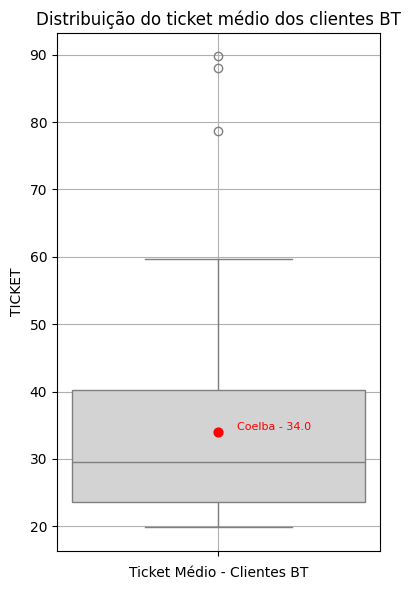

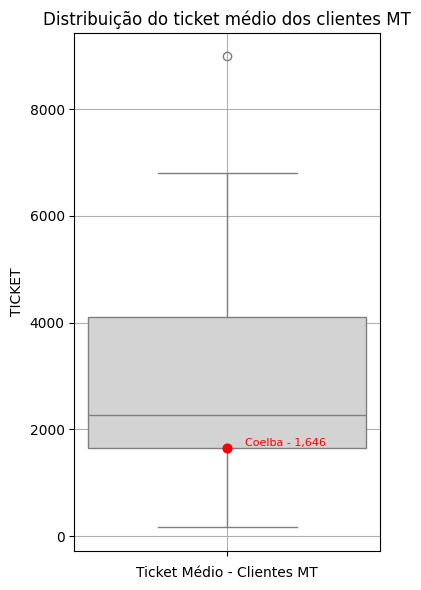

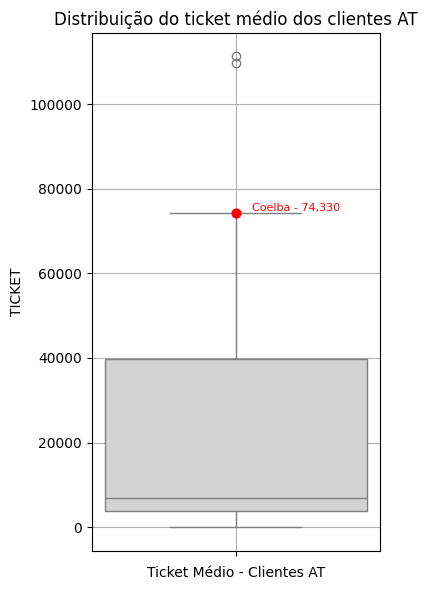

In [309]:
# Gráfico - BT:
plt.subplots(figsize=(4,6))
plt.grid()
sns.boxplot(data=dfGraph[dfGraph['TENSAO'] == 'BT'], y='TICKET', color='lightgray')
plt.title('Distribuição do ticket médio dos clientes BT')
plt.xlabel('Ticket Médio - Clientes BT')
plt.grid(True)

# Marcar ponto da Coelba:
valor_coelba = dfGraph[dfGraph['TENSAO'] == 'BT'][dfGraph[dfGraph['TENSAO'] == 'BT']['SIGAGENTE'].str.contains('COELBA')]['TICKET'].values
if len(valor_coelba) > 0:
    plt.scatter(x=0, y=valor_coelba[0], color='red', s=40, label='Coelba', zorder=5)

    plt.text(
        x=0.05, y=valor_coelba[0],
        s=f'Coelba - {valor_coelba[0]:.1f}',
        color='red',
        fontsize=8,
        va='bottom',
        ha='left'
    )

plt.tight_layout()
plt.show()

# Gráfico - MT:
plt.subplots(figsize=(4,6))
plt.grid()
sns.boxplot(data=dfGraph[dfGraph['TENSAO'] == 'MT'], y='TICKET', color='lightgray')
plt.title('Distribuição do ticket médio dos clientes MT')
plt.xlabel('Ticket Médio - Clientes MT')
plt.grid(True)

# Marcar ponto da Coelba:
valor_coelba = dfGraph[dfGraph['TENSAO'] == 'MT'][dfGraph[dfGraph['TENSAO'] == 'MT']['SIGAGENTE'].str.contains('COELBA')]['TICKET'].values
if len(valor_coelba) > 0:
    plt.scatter(x=0, y=valor_coelba[0], color='red', s=40, label='Coelba', zorder=5)

    plt.text(
        x=0.05, y=valor_coelba[0],
        s=f'Coelba - {valor_coelba[0]:,.0f}',
        color='red',
        fontsize=8,
        va='bottom',
        ha='left'
    )

plt.tight_layout()
plt.show()

# Gráfico - AT:
plt.subplots(figsize=(4,6))
plt.grid()
sns.boxplot(data=dfGraph[dfGraph['TENSAO'] == 'AT'], y='TICKET', color='lightgray')
plt.title('Distribuição do ticket médio dos clientes AT')
plt.xlabel('Ticket Médio - Clientes AT')
plt.grid(True)

# Marcar ponto da Coelba:
valor_coelba = dfGraph[dfGraph['TENSAO'] == 'AT'][dfGraph[dfGraph['TENSAO'] == 'AT']['SIGAGENTE'].str.contains('COELBA')]['TICKET'].values
if len(valor_coelba) > 0:
    plt.scatter(x=0, y=valor_coelba[0], color='red', s=40, label='Coelba', zorder=5)

    plt.text(
        x=0.05, y=valor_coelba[0],
        s=f'Coelba - {valor_coelba[0]:,.0f}',
        color='red',
        fontsize=8,
        va='bottom',
        ha='left'
    )

plt.tight_layout()
plt.show()


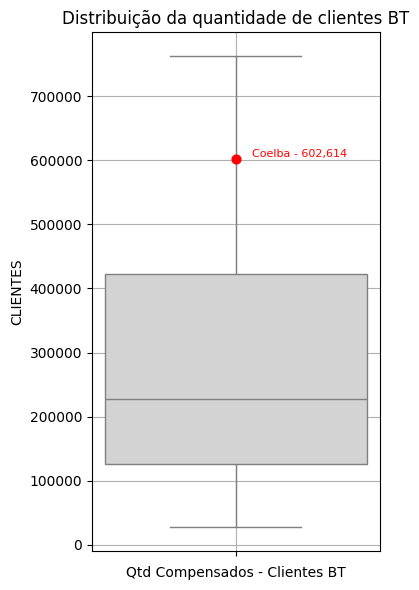

<Figure size 640x480 with 0 Axes>

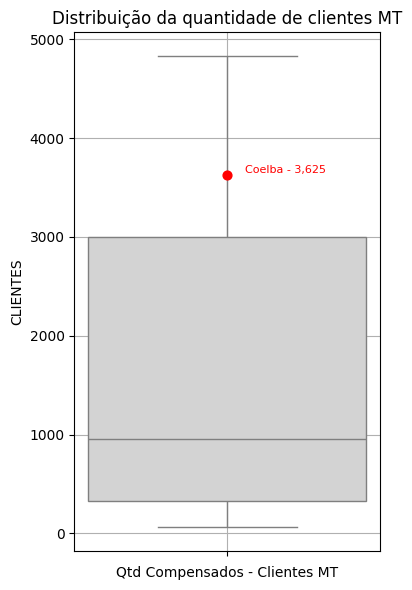

<Figure size 640x480 with 0 Axes>

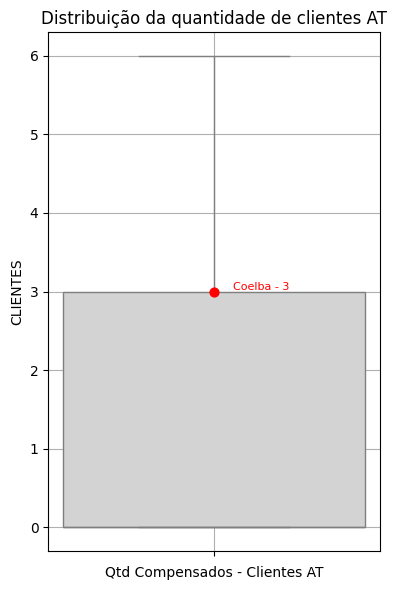

<Figure size 640x480 with 0 Axes>

In [310]:
# Gráfico - BT:
plt.subplots(figsize=(4,6))
plt.grid()
sns.boxplot(data=dfGraph[dfGraph['TENSAO'] == 'BT'], y='CLIENTES', color='lightgray',  showfliers=False)
plt.title('Distribuição da quantidade de clientes BT')
plt.xlabel('Qtd Compensados - Clientes BT')
plt.grid(True)

# Marcar ponto da Coelba:
valor_coelba = dfGraph[dfGraph['TENSAO'] == 'BT'][dfGraph[dfGraph['TENSAO'] == 'BT']['SIGAGENTE'].str.contains('COELBA')]['CLIENTES'].values
if len(valor_coelba) > 0:
    plt.scatter(x=0, y=valor_coelba[0], color='red', s=40, label='Coelba', zorder=5)

    plt.text(
        x=0.05, y=valor_coelba[0],
        s=f'Coelba - {valor_coelba[0]:,.0f}',
        color='red',
        fontsize=8,
        va='bottom',
        ha='left'
    )

plt.tight_layout()
plt.show()

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-quantidade-clientes-compensados-bt.png'))

# Gráfico - MT:
plt.subplots(figsize=(4,6))
plt.grid()
sns.boxplot(data=dfGraph[dfGraph['TENSAO'] == 'MT'], y='CLIENTES', color='lightgray',  showfliers=False)
plt.title('Distribuição da quantidade de clientes MT')
plt.xlabel('Qtd Compensados - Clientes MT')
plt.grid(True)

# Marcar ponto da Coelba:
valor_coelba = dfGraph[dfGraph['TENSAO'] == 'MT'][dfGraph[dfGraph['TENSAO'] == 'MT']['SIGAGENTE'].str.contains('COELBA')]['CLIENTES'].values
if len(valor_coelba) > 0:
    plt.scatter(x=0, y=valor_coelba[0], color='red', s=40, label='Coelba', zorder=5)

    plt.text(
        x=0.05, y=valor_coelba[0],
        s=f'Coelba - {valor_coelba[0]:,.0f}',
        color='red',
        fontsize=8,
        va='bottom',
        ha='left'
    )

plt.tight_layout()
plt.show()

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-quantidade-clientes-compensados-mt.png'))

# Gráfico - AT:
plt.subplots(figsize=(4,6))
plt.grid()
sns.boxplot(data=dfGraph[dfGraph['TENSAO'] == 'AT'], y='CLIENTES', color='lightgray', showfliers=False)
plt.title('Distribuição da quantidade de clientes AT')
plt.xlabel('Qtd Compensados - Clientes AT')
plt.grid(True)

# Marcar ponto da Coelba:
valor_coelba = dfGraph[dfGraph['TENSAO'] == 'AT'][dfGraph[dfGraph['TENSAO'] == 'AT']['SIGAGENTE'].str.contains('COELBA')]['CLIENTES'].values
if len(valor_coelba) > 0:
    plt.scatter(x=0, y=valor_coelba[0], color='red', s=40, label='Coelba', zorder=5)

    plt.text(
        x=0.05, y=valor_coelba[0],
        s=f'Coelba - {valor_coelba[0]:,.0f}',
        color='red',
        fontsize=8,
        va='bottom',
        ha='left'
    )

plt.tight_layout()
plt.show()

# Salvando a imagem:
plt.tight_layout()
plt.savefig(os.path.join(IMAGES_PATH, 'compensacao-quantidade-clientes-compensados-at.png'))

In [ ]:
# ! Análise de clientes compensados por Localização:
# Montagem do novo dataframe:
dfGraph = pd.merge(dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'CLIENTES')][['SIGAGENTE','VLRINDICEENVIADO','NUC','NUC_CATEGORIA','TENSAO','URBANO']].groupby(by=['SIGAGENTE','NUC','NUC_CATEGORIA','TENSAO','URBANO'])['VLRINDICEENVIADO'].sum().reset_index(),
                   dfCompT[(dfCompT['ANOINDICE'] == 2025) & (dfCompT['INDICADOR'] == 'DINHEIRO')][['SIGAGENTE','VLRINDICEENVIADO','TENSAO','URBANO']].groupby(by=['SIGAGENTE','TENSAO','URBANO'])['VLRINDICEENVIADO'].sum().reset_index(),
                   how = 'left',
                    on = ['SIGAGENTE','TENSAO','URBANO'])
dfGraph = dfGraph.rename(columns={'VLRINDICEENVIADO_x':'CLIENTES','VLRINDICEENVIADO_y':'VALOR'})
dfGraph['TICKET'] = dfGraph['VALOR']/dfGraph['CLIENTES']

# Análise:
dfGraph[dfGraph['NUC_CATEGORIA'] == 'Grande'].assign(
    CLIENTES=lambda x: x['CLIENTES'].apply(lambda v: f'{v:,.0f}'),
    VALOR=lambda x: x['VALOR'].apply(lambda v: f'{v:,.2f}'),
    TICKET=lambda x: x['TICKET'].apply(lambda v: f'{v:,.2f}'),
    ).sort_values(by=['TENSAO','URBANO'])[['SIGAGENTE','TENSAO','URBANO','CLIENTES','VALOR','TICKET']]